<a href="https://colab.research.google.com/github/MatienkoAndrew/notebooks/blob/main/_homework_part1_gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q transformers datasets tokenizers

# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего.

In [ ]:
emotion_dataset = load_dataset("emotion")

Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
##-- examples
for (emotion, emotion_label) in zip(np.unique(emotion_dataset["train"]["label"]), ["sadness", "joy", "love", "anger", "fear", "surprise"]):
    print(f"Emotion: {emotion_label}")
    print("Examples:")
    indices = np.where(np.array(emotion_dataset["train"]["label"]) == emotion)[0]
    for text in np.array(emotion_dataset["train"]["text"])[indices[:5]]:
        print(f"- {text}")
    print()


Emotion: sadness
Examples:
- i didnt feel humiliated
- i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
- ive been feeling a little burdened lately wasnt sure why that was
- i feel like i have to make the suffering i m seeing mean something
- i feel low energy i m just thirsty

Emotion: joy
Examples:
- i have been with petronas for years i feel that petronas has performed well and made a huge profit
- i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter
- i have immense sympathy with the general point but as a possible proto writer trying to find time to write in the corners of life and with no sign of an agent let alone a publishing contract this feels a little precious
- i do not feel reassured anxiety is on each side
- i have the feeling she was amused and delighted

Emotion: love
Examples:
- i am ever feeling nostalgic about the fireplace i will know that it is still 

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

0

In [ ]:
len(emotion_dataset["train"])

16000

In [ ]:
set(emotion_dataset['train']['label'])

{0, 1, 2, 3, 4, 5}

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained('distilgpt2')

In [ ]:
tokenizer

GPT2TokenizerFast(name_or_path='distilgpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True)

In [ ]:
# tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [ ]:
emotion_dataset["train"]["text"][0], tokenizer.tokenize(emotion_dataset["train"]["text"][0])

('i didnt feel humiliated', ['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated'])

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0],
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
tokenizer_output = tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0],
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

In [ ]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}

    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]['text'][idx]
        label = self.dataset[self.part]['label'][idx]

        tokenizer_output = tokenizer.encode_plus(
            text,
            max_length=self.max_length, # максимальная длина текста
            padding="max_length", # надо ли добавлять паддинг в конце?
            return_tensors="pt", # возвращает pytorch тензоры
        )

        target = torch.tensor(self.label2num[label])
        return {
            "input_ids": tokenizer_output['input_ids'],
            "mask": tokenizer_output['attention_mask'],
            "target": target
        }

    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [ ]:
train_dataset = TweetDataset('train')
valid_dataset = TweetDataset('validation') # validation
test_dataset = TweetDataset('test')

In [ ]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

In [ ]:
model_0

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=6, bias=False)
)

Подготовь оптимайзер и критерий:

In [ ]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.AdamW(model_0.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
train_dataset[0]

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 502

In [ ]:
tokens = train_dataset[0]['input_ids'] # Получи токены из датасета
mask = train_dataset[0]['mask'] # Получи маску из датасета
label = train_dataset[0]['target']
out = model_0(input_ids=tokens.to(device), attention_mask=mask.to(device), labels=label.to(device)) # Посмотри на аутпут
out

SequenceClassifierOutputWithPast(loss=tensor(1.8639, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[ 0.2767,  0.9991,  0.0810,  0.5278, -0.7973,  0.2152]],
       device='cuda:0', grad_fn=<IndexBackward0>), past_key_values=((tensor([[[[-0.3699,  0.2761, -0.6099,  ...,  0.4133, -0.5014, -0.2307],
          [-0.2302,  0.1080,  0.5104,  ..., -0.0918,  1.0375,  0.4579],
          [ 0.3196, -1.0753, -0.0404,  ..., -0.4673, -0.8863,  0.3699],
          ...,
          [ 0.6538, -0.1156, -0.3439,  ...,  0.0704,  0.7813, -0.1201],
          [ 0.7790, -0.6434, -0.3133,  ..., -0.8176, -0.1260, -0.3792],
          [ 0.9432, -1.1702, -0.9049,  ...,  0.2821, -0.2846, -0.4506]],

         [[-0.1928,  1.4410, -0.3795,  ...,  0.7751,  0.1200,  0.0026],
          [-0.7161,  0.0390,  0.8715,  ...,  0.5448, -0.6752,  0.0881],
          [ 0.0253,  0.3011,  1.0354,  ..., -0.4329, -0.2512,  0.1841],
          ...,
          [ 0.4864,  0.8975,  0.5135,  ...,  0.1111,  0.0655,  0.0201],
        

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [ ]:
from tqdm.notebook import tqdm

num_epochs = 2

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f'Training epoch {e}'):
        optimizer.zero_grad()
        batch_x, mask, batch_y = batch['input_ids'], batch['mask'], batch['target']
        loss = model_0(
            batch['input_ids'].squeeze().to(device),
            attention_mask=batch['mask'].to(device),
            labels=batch['target'].to(device)
            )['loss']
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        torch.cuda.empty_cache()

    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            output = model_0(
                batch['input_ids'].squeeze().to(device),
                attention_mask = batch['mask'].to(device),
                labels = batch['target'].to(device)
            )
            valid_loss += output['loss'].item()
            valid_acc += (output['logits'].argmax(1) == batch['target'].to(device)).sum().item()

            torch.cuda.empty_cache()

    scheduler.step()
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}"
          )


# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        output = model_0(
            batch['input_ids'].squeeze().to(device),
            attention_mask = batch['mask'].to(device),
            labels = batch['target'].to(device)
        )
        test_acc += (output['logits'].argmax(1) == batch['target'].to(device)).sum().item()

        torch.cuda.empty_cache()
print(f"Test Acc: {test_acc / len(test_loader)}")

Training epoch 0:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.5182708554267883,Valid Loss: 1.3690248616039753,Valid Acc: 30.0625


Training epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.1925682454109192,Valid Loss: 1.0011330042034388,Valid Acc: 39.5625


  0%|          | 0/32 [00:00<?, ?it/s]

Test Acc: 40.0625


In [ ]:
from tqdm.notebook import tqdm

num_epochs = 2

accumulation_steps = 4
optimizer.zero_grad()

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for ix, batch in enumerate(tqdm(train_loader, desc=f'Training epoch {e}')):
        optimizer.zero_grad()
        batch_x, mask, batch_y = batch['input_ids'], batch['mask'], batch['target']
        loss = model_0(
            batch['input_ids'].squeeze().to(device),
            attention_mask=batch['mask'].to(device),
            labels=batch['target'].to(device)
            )['loss']
        loss /= accumulation_steps # Нормализовать loss (необязательно)
        loss.backward()
        # Если это последний шаг накопления градиента, то выполнить шаг оптимизации
        if ix % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache()
        train_loss += loss.item()

    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            output = model_0(
                batch['input_ids'].squeeze().to(device),
                attention_mask = batch['mask'].to(device),
                labels = batch['target'].to(device)
            )
            valid_loss += output['loss'].item()
            valid_acc += (output['logits'].argmax(1) == batch['target'].to(device)).sum().item()

            torch.cuda.empty_cache()

    scheduler.step()
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}"
          )


# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        output = model_0(
            batch['input_ids'].squeeze().to(device),
            attention_mask = batch['mask'].to(device),
            labels = batch['target'].to(device)
        )
        test_acc += (output['logits'].argmax(1) == batch['target'].to(device)).sum().item()

        torch.cuda.empty_cache()
print(f"Test Acc: {test_acc / len(test_loader)}")

Training epoch 0:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.2134449161887169,Valid Loss: 0.9311307817697525,Valid Acc: 41.96875


Training epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1999879375100136,Valid Loss: 0.9354632068425417,Valid Acc: 42.0625


  0%|          | 0/32 [00:00<?, ?it/s]

Test Acc: 41.53125


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [ ]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))

    return np.array(attn)

In [ ]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
text = emotion_dataset["train"]["text"][0] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

<ipython-input-43-0d31a6ec8e7d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
<ipython-input-43-0d31a6ec8e7d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+seq, fontsize=16)


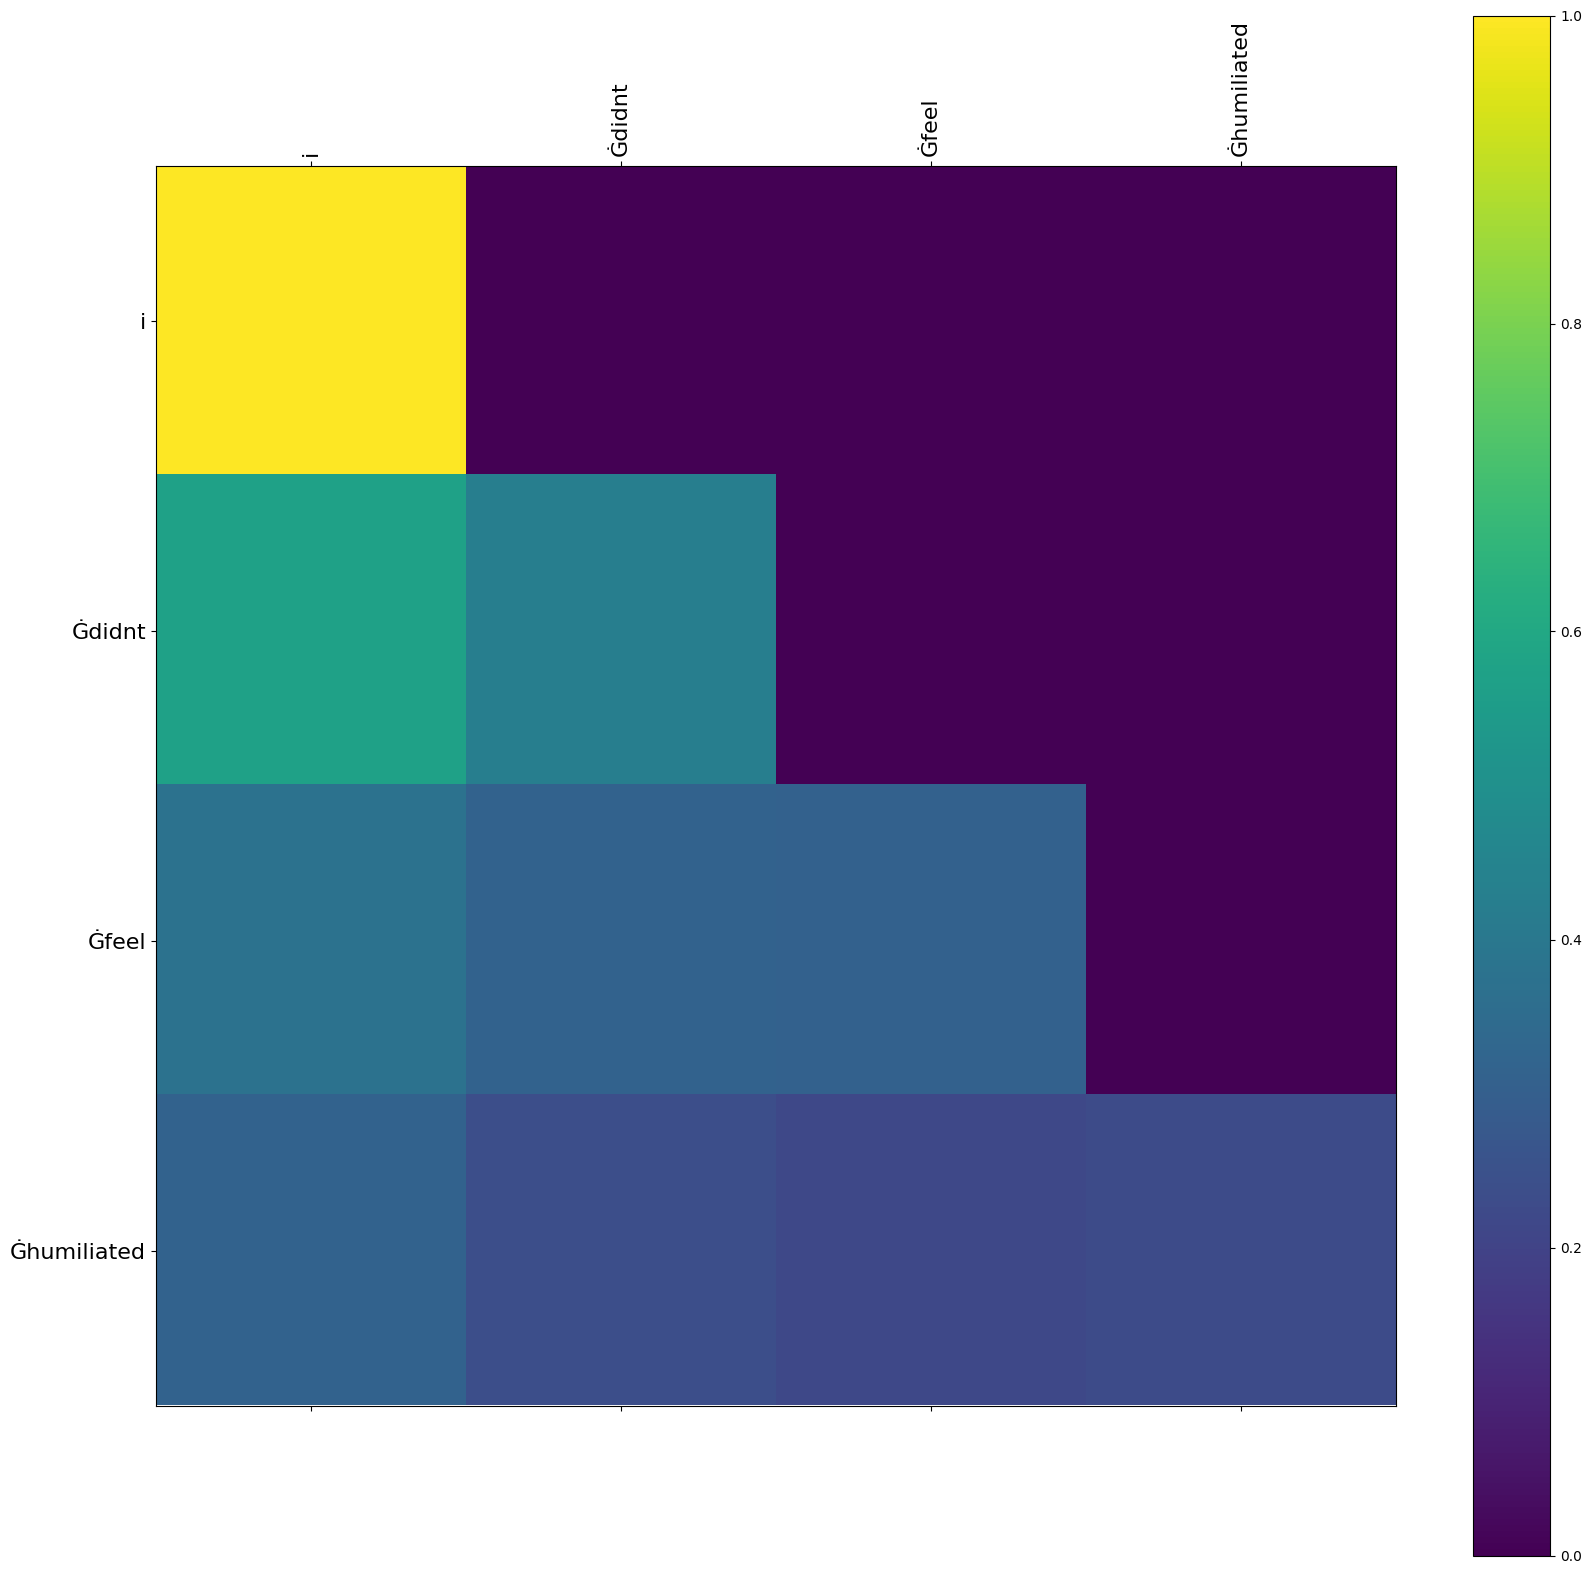

In [ ]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [ ]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2",
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.AdamW(model_0.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [ ]:
from tqdm.notebook import tqdm

num_epochs = 2

accumulation_steps = 4
optimizer.zero_grad()

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for ix, batch in enumerate(tqdm(train_loader, desc=f'Training epoch {e}')):
        optimizer.zero_grad()
        batch_x, mask, batch_y = batch['input_ids'], batch['mask'], batch['target']
        loss = model_1(
            batch['input_ids'].squeeze().to(device),
            attention_mask=batch['mask'].to(device),
            labels=batch['target'].to(device)
            )['loss']
        loss /= accumulation_steps # Нормализовать loss (необязательно)
        loss.backward()
        # Если это последний шаг накопления градиента, то выполнить шаг оптимизации
        if ix % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache()
        train_loss += loss.item()

    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            output = model_1(
                batch['input_ids'].squeeze().to(device),
                attention_mask = batch['mask'].to(device),
                labels = batch['target'].to(device)
            )
            valid_loss += output['loss'].item()
            valid_acc += (output['logits'].argmax(1) == batch['target'].to(device)).sum().item()

            torch.cuda.empty_cache()

    scheduler.step()
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}"
          )


# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        output = model_1(
            batch['input_ids'].squeeze().to(device),
            attention_mask = batch['mask'].to(device),
            labels = batch['target'].to(device)
        )
        test_acc += (output['logits'].argmax(1) == batch['target'].to(device)).sum().item()

        torch.cuda.empty_cache()
print(f"Test Acc: {test_acc / len(test_loader)}")

Training epoch 0:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.6218176894187927,Valid Loss: 2.6267749965190887,Valid Acc: 17.09375


Training epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.621273702263832,Valid Loss: 2.6267749965190887,Valid Acc: 17.09375


  0%|          | 0/32 [00:00<?, ?it/s]

Test Acc: 18.125


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [ ]:
text = emotion_dataset["train"]["text"][0] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

<ipython-input-43-0d31a6ec8e7d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
<ipython-input-43-0d31a6ec8e7d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+seq, fontsize=16)


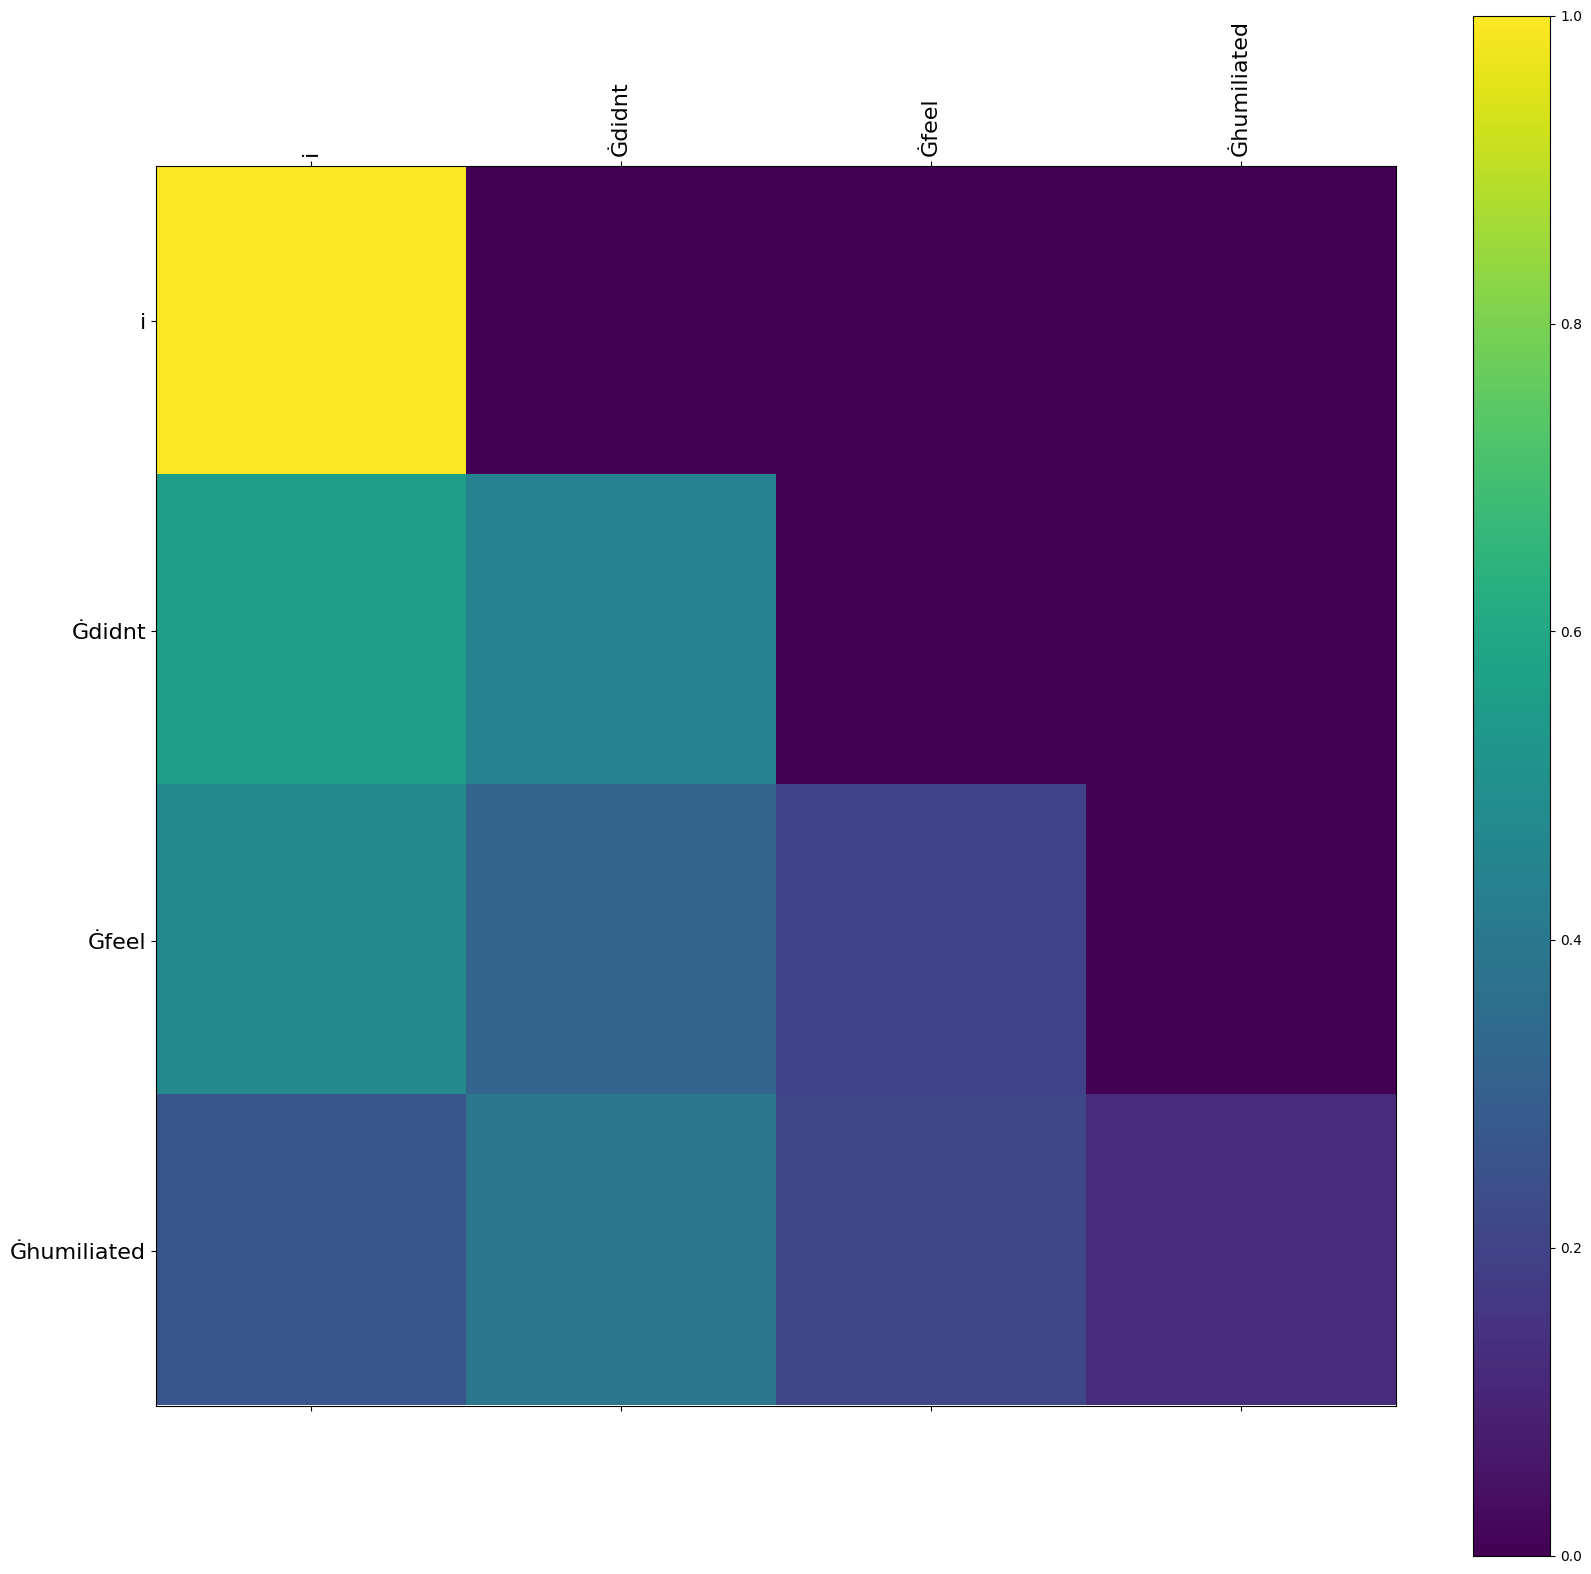

In [ ]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше?
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

## Inference

In [ ]:
##-- model_1
from torch.nn.functional import softmax

idx = np.random.choice(np.arange(len(emotion_dataset['train']['text'])), size=1)[0]
emotion_dataset['train']['text'][idx], emotion_dataset['train']['label'][idx]
text = emotion_dataset['train']['text'][idx]
encoded_input = tokenizer.encode_plus(
            text,
            max_length=128, # максимальная длина текста
            padding="max_length", # надо ли добавлять паддинг в конце?
            return_tensors="pt", # возвращает pytorch тензоры
        ).to(device)
outputs = model_1(encoded_input['input_ids'], attention_mask=encoded_input['attention_mask'])

logits = outputs.logits
probabilities = softmax(logits, dim=-1)
predicted_class = torch.argmax(probabilities).item()

print(f"Predicted class: {predicted_class}")
print(f"True class: {emotion_dataset['train']['label'][idx]}")


Predicted class: 0
True class: 1


In [ ]:
##-- model_0
from torch.nn.functional import softmax

idx = np.random.choice(np.arange(len(emotion_dataset['train']['text'])), size=1)[0]
emotion_dataset['train']['text'][idx], emotion_dataset['train']['label'][idx]
text = emotion_dataset['train']['text'][idx]
encoded_input = tokenizer.encode_plus(
            text,
            max_length=128, # максимальная длина текста
            padding="max_length", # надо ли добавлять паддинг в конце?
            return_tensors="pt", # возвращает pytorch тензоры
        ).to(device)
outputs = model_0(encoded_input['input_ids'], attention_mask=encoded_input['attention_mask'])

logits = outputs.logits
probabilities = softmax(logits, dim=-1)
predicted_class = torch.argmax(probabilities).item()

print(f"Predicted class: {predicted_class}")
print(f"True class: {emotion_dataset['train']['label'][idx]}")


Predicted class: 4
True class: 3


# Save models

In [ ]:
model_0

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=6, bias=False)
)

In [ ]:
FILENAME = 'DistilGPT2ForSequenceClassification_notpretrained.pth'
torch.save(model_0.state_dict(), FILENAME)

In [ ]:
FILENAME = 'DistilGPT2ForSequenceClassification_pretrained.pth'
torch.save(model_1.state_dict(), FILENAME)

In [ ]:
# ! pip install onnx

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
)
model_0_read = GPT2ForSequenceClassification(config=config).to(device)
# model = GPT2ForSequenceClassification(num_labels=6)
model_0_read.load_state_dict(torch.load("DistilGPT2ForSequenceClassification_notpretrained.pth"))
model_0_read.eval()

dummy_input = torch.randint(high=tokenizer.vocab_size, size=(1, 128)).to(device)
torch.onnx.export(model_0_read, dummy_input, "model_0.onnx")


/usr/local/lib/python3.10/dist-packages/torch/onnx/symbolic_opset9.py:5589: UserWarning: Exporting aten::index operator of advanced indexing in opset 14 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  warnings.warn(


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
model_1_read = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2",
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to(device)
# model = GPT2ForSequenceClassification(num_labels=6)
model_1_read.load_state_dict(torch.load("DistilGPT2ForSequenceClassification_pretrained.pth"))
model_1_read.eval()

dummy_input = torch.randint(high=tokenizer.vocab_size, size=(1, 128)).to(device)
torch.onnx.export(model_1_read, dummy_input, "DistilGPT2ForSequenceClassification_pretrained.onnx")


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/onnx/symbolic_opset9.py:5589: UserWarning: Exporting aten::index operator of advanced indexing in opset 14 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  warnings.warn(


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

